In [1]:
import eqop
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

In [2]:
z, Ho, k, k_c, k_m, k_uc, k_lcm, delta, Zo, Zf, To, Tf, Ti, Tm, Zm, Zb, Tb, Qm, Qo, Qi, Zi, Hc, Huc, Hlc = sp.symbols(
    'z, H_{0}, k, k_c, k_m, k_uc, k_lcm, \delta, Z_{0}, Z_{f}, T_{0}, T_{f}, T_{i}, T_{m}, Z_{m}, Z_{b}, T_{b}, Q_{m}, Q_{0}, Q_{i}, Z_{i}, H_{c}, H_{uc}, H_{lc}'
)
T, Q, H = sp.symbols('T, Q, H', cls=sp.Function)
#sp.init_printing(latex_mode='equation*')
sp.init_printing()

In [3]:
substitutions = {
  Ho: 3.e-6,
  k: 2.0,
  k_c: 3.0,
  k_m: 1.0,
  k_uc: 3.0,
  k_lcm: 1.0,
  delta: 10.e3,
  Zo: 0,
  Zf: 100.e3,
  To: 0,
  Tf: 1300,
  Zm: 50.e3,
  Zi: 10.e3,
  Hlc: 4.e-7,
  Huc: 1.65e-6
}

In [4]:
domain = np.linspace(0,100.e3,101)

In [5]:
#def printeq(expr, number=None, text="eq."):
#    if number is not None:
#        result = "$${} \;({}{})$$".format(sp.latex(expr), text, number)
#    else:
#        result = "$${}$$".format(sp.latex(expr))
#    display(Latex(result))

In [6]:
def printeq(expr, number=None, text="eq."):
    if number is not None:
        result = "$\\displaystyle {} \;({}{})$".format(sp.latex(expr), text, number)
    else:
        result = "$\\displaystyle {}$".format(sp.latex(expr))
    display(Latex(result))

In [7]:
def validate_columns(columns):
    if isinstance(columns, tuple):
        return list(columns)
    else:
        return [columns]

In [8]:
def savetxt(filename, columns):
    cols = validate_columns(columns)
    results = []
    for col in cols:
        if callable(col):
            results.append(col(domain))
        else:
            results.append(col)
    results = tuple(results) 
    return np.savetxt(filename, np.column_stack((domain,) + results))

In [9]:
def model_values(crust=None, lower_crust=None, mantle=None):
    Zi_idx = np.where(np.isclose(domain, substitutions[Zm]))[0][0]
    Zm_idx = np.where(np.isclose(domain, substitutions[Zm]))[0][0]
    crust_values = crust(domain)[:Zm_idx]
    mantle_values = mantle(domain)[Zm_idx:]
    values = np.concatenate((crust_values, mantle_values)) 
    if lower_crust is not None:
        values[Zi_idx:Zm_idx] = lower_crust(domain)[Zi_idx:Zm_idx]
    return values

<hr style="color:black"/>

# Ecuación de Calor

In [10]:
Eq_0 = sp.Eq(k*T(z).diff(z,2), -H(z))
printeq(Eq_0, 0)

<IPython.core.display.Latex object>

Condiciones de Borde Genrales

1. Q = -Qm en z = Zm\
(Q = -Qm porque se asume que Qm fluye en la dirección negativa de z)

In [11]:
cond1 = sp.Eq(-k*T(Zm).diff(Zm), -Qm)
printeq(cond1, 1, "cond.")

<IPython.core.display.Latex object>

In [12]:
cond1_c = cond1.subs({k: k_lcm})
printeq(cond1_c, 1.1, "cond.")

<IPython.core.display.Latex object>

2. T = Tm en z = Zm

In [13]:
cond2 = sp.Eq(T(Zm), Tm)
printeq(cond2, 2, "cond.")

<IPython.core.display.Latex object>

<hr style="color:black"/>

## Ecuaciones en el Manto Litosférico

Condiciones de borde del Manto Litosférico

3. T = Tf en Z = Zf

In [14]:
cond3 = sp.Eq(T(Zf), Tf)
printeq(cond3, 3, "cond.")

<IPython.core.display.Latex object>

La generación de calor en el manto es cero.

In [15]:
Eq_1 = sp.Eq(H(z), 0)
printeq(Eq_1, 1)

<IPython.core.display.Latex object>

Reemplazando eq.1 en eq.0

In [16]:
Heat_eq_mantle = Eq_0.subs(H(z), sp.solve(Eq_1, H(z))[0])
printeq(Heat_eq_mantle)

<IPython.core.display.Latex object>

Integrando con respecto a dz en ambos lados de la ecuación

In [17]:
e = Heat_eq_mantle.bsop(lambda bs: sp.integrate(bs, z)) # integrar
expr = e.rhsop(lambda rhs: rhs + sp.var('C1')) # sumar constante
printeq(expr)

<IPython.core.display.Latex object>

Evaluando la expresión previa en z = Zm y luego reemplazando la Cond.1 en el resultado

In [18]:
e = cond1.bsop(lambda bs: bs*-1)
e2 = expr.subs({z: Zm})
expr2 = e2.subs({e2.lhs: sp.solve(e, e2.lhs)[0]})
printeq(expr2)

<IPython.core.display.Latex object>

Combinando las dos expresiones previas

In [19]:
Eq_2 = expr.subs({'C1': sp.solve(expr2, 'C1')[0]})
printeq(Eq_2,2)

<IPython.core.display.Latex object>

Integrando eq.2 dentro del manto litosférico

In [20]:
expr = Eq_2.bsop(lambda bs: sp.integrate(bs,(z,z,Zf)))
printeq(expr)

<IPython.core.display.Latex object>

Reemplazando la Cond.2 en la expresión previa

In [21]:
e = expr.subs({T(Zf): sp.solve(cond3, T(Zf))[0]})
Eq_3 = sp.Eq(T(z), sp.solve(e, T(z))[0])
printeq(Eq_3.expand(),3)

<IPython.core.display.Latex object>

In [22]:
Eq_3_c = Eq_3.subs({k: k_lcm})
printeq(Eq_3_c.expand(),3.1)

<IPython.core.display.Latex object>

<hr style="color:black"/>

## Ecuaciones en la Corteza

Condiciones de borde de la Corteza

4. T = 0 en Z = 0

In [23]:
cond4 = sp.Eq(T(0), 0)
printeq(cond4, 4, "cond.")

<IPython.core.display.Latex object>

<hr style="color:black"/>

### Modelo M1

En el modelo M1, en la corteza la generación de calor decrece exponencialmente, desde un valor H0 en la superficie y con un factor de escala $\delta$ 

In [24]:
Eq_4 = sp.Eq(H(z), Ho*sp.exp(-z/delta))
printeq(Eq_4,4)

<IPython.core.display.Latex object>

Reemplazando la eq.4 en la eq.0

In [25]:
Heat_eq_crust = Eq_0.subs({H(z): sp.solve(Eq_4, H(z))[0]})
printeq(Heat_eq_crust)

<IPython.core.display.Latex object>

Integrando con respecto a dz

In [26]:
e = Heat_eq_crust.bsop(lambda bs: sp.integrate(bs, z))
Eq_5 = e.rhsop(lambda rhs: rhs + sp.var('C2'))
printeq(Eq_5,5)

<IPython.core.display.Latex object>

Evaluando la eq.5 en z = Zm y reemplazando la cond.1 en el resultado

In [27]:
e = Eq_5.subs({z: Zm})
e = e.subs(e.lhs, sp.solve(cond1, e.lhs)[0])
Eq_6 = sp.Eq(C2, sp.solve(e, 'C2')[0]) # TODO: Averiguar por qué puedo ocupar C2 si no lo he definido ??
printeq(Eq_6,6)

<IPython.core.display.Latex object>

Reemplazando la eq.6 en la eq.5

In [28]:
expr = Eq_5.subs(C2, sp.solve(Eq_6, 'C2')[0])
printeq(expr)

<IPython.core.display.Latex object>

Integrando la expresión anterior

In [29]:
e = expr.bsop(lambda bs: sp.integrate(bs, z))
e = sp.Eq(T(z), sp.solve(e, T(z))[0])
Eq_7 = e.rhsop(lambda rhs: rhs + sp.var('C3'))
printeq(Eq_7,7)

<IPython.core.display.Latex object>

Evaluando la eq.7 en z = 0 y reemplazando la cond.4 en el resultado

In [30]:
e = Eq_7.subs(z, 0)
e = e.subs(T(0), sp.solve(cond4, T(0))[0])
Eq_8 = sp.Eq(C3, sp.solve(e, 'C3')[0])
printeq(Eq_8,8)

<IPython.core.display.Latex object>

Reemplazando la eq.8 en la eq.7

In [31]:
Eq_9 = Eq_7.subs('C3', sp.solve(Eq_8, 'C3')[0])
printeq(Eq_9,9)

<IPython.core.display.Latex object>

<hr style="color:black"/>

Evaluando la eq.9 y la eq.3 en z = Zm e igualando sus respectivos resultados

In [32]:
e1 = sp.solve(Eq_3.subs(z,Zm), T(Zm))[0]
e2 = sp.solve(Eq_9.subs(z,Zm), T(Zm))[0]
e = sp.Eq(e1, e2)
Eq_10 = sp.Eq(Qm, sp.solve(e, Qm)[0])
printeq(Eq_10.expand(),10)

<IPython.core.display.Latex object>

<hr style="color:black"/>

**Ecuación final para temperatura en la corteza del modelo M1**

In [33]:
Eq_12 = Eq_9.subs(Qm, Eq_10.args[1])
printeq(sp.expand(Eq_12),12)

<IPython.core.display.Latex object>

In [34]:
Eq_12_b = Eq_12.subs({k: k_c})

In [35]:
#Eq_12_simp = sp.Eq(T(z), (1/k)*(-Ho*(delta**2)*sp.exp(-z/delta)-z*(Ho*delta*sp.exp(-Zm/delta)-Qm)+Ho*(delta**2)))
#Eq_12_simp = Eq_12_simp.subs(Qm, Eq_10.args[1])
#Eq_12_simp.expand().args[1] - Eq_12.expand().args[1]

**Ecuación final para temperatura en el manto del modelo M1**

In [36]:
Eq_13 = Eq_3.subs(Qm, Eq_10.args[1])
printeq(sp.expand(Eq_13),13)

<IPython.core.display.Latex object>

In [37]:
Eq_13_b = Eq_13.subs({k: k_m})

In [38]:
#Eq_13_simp = sp.Eq(T(z), (Qm/k)*(z-Zf)+Tf)
#Eq_13_simp = Eq_13_simp.subs(Qm, Eq_10.args[1])
#Eq_13_simp.expand().args[1] - Eq_13.expand().args[1]

**Ecuación final para calor en la corteza del modelo M1**

In [39]:
Eq_14 = sp.Eq(k*Eq_12.args[0].diff(z),k*Eq_12.args[1].diff(z))
printeq(sp.expand(Eq_14),14)

<IPython.core.display.Latex object>

In [40]:
Eq_14_b = Eq_14.subs({k: k_c})

In [41]:
#Eq_14_simp = sp.Eq(Q(z), Ho*delta*sp.exp(-z/delta)-Ho*delta*sp.exp(-Zm/delta)+Qm)
#Eq_14_simp = Eq_14_simp.subs(Qm, Eq_10.args[1])
#Eq_14_simp.expand().args[1] - Eq_14.expand().args[1]

**Ecuación final para calor en el manto del modelo M1**

In [42]:
Eq_15 = sp.Eq(k*Eq_13.args[0].diff(z), k*Eq_13.args[1].diff(z)) 
printeq(sp.expand(Eq_15),15)

<IPython.core.display.Latex object>

In [43]:
Eq_15_b = Eq_15.subs({k: k_m})

In [44]:
#Eq_15_simp = sp.Eq(Q(z), Qm)
#Eq_15_simp = Eq_15_simp.subs(Qm, Eq_10.args[1])
#Eq_15_simp.expand().args[1] - Eq_15.expand().args[1]

<hr style="color:black"/>

In [45]:
T_z_crust_M1 = sp.lambdify(z,Eq_12.args[1].subs(substitutions))
T_z_mantle_M1 = sp.lambdify(z,Eq_13.args[1].subs(substitutions))
T_z_crust_M1_b = sp.lambdify(z,Eq_12_b.args[1].subs(substitutions))
T_z_mantle_M1_b = sp.lambdify(z,Eq_13_b.args[1].subs(substitutions))
Q_z_crust_M1 = sp.lambdify(z,Eq_14.args[1].subs(substitutions))
Q_z_mantle_M1 = sp.lambdify(z,Eq_15.args[1].subs(substitutions))
Q_z_crust_M1_b = sp.lambdify(z,Eq_14_b.args[1].subs(substitutions))
Q_z_mantle_M1_b = sp.lambdify(z,Eq_15_b.args[1].subs(substitutions))


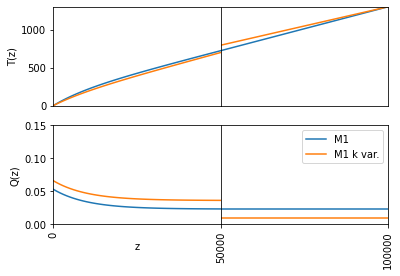

In [46]:
fig, axes = plt.subplots(nrows=2,ncols=2)
axes[0][0].plot(domain, T_z_crust_M1(domain), label="M1")
axes[0][1].plot(domain, T_z_mantle_M1(domain), label="M1")
axes[0][0].plot(domain, T_z_crust_M1_b(domain), label="M1 k var.")
axes[0][1].plot(domain, T_z_mantle_M1_b(domain), label="M1 k var.")
axes[1][0].plot(domain, Q_z_crust_M1(domain), label="M1")
axes[1][1].plot(domain, np.repeat(Q_z_mantle_M1(domain),len(domain)), label="M1")
axes[1][0].plot(domain, Q_z_crust_M1_b(domain), label="M1 k var.")
axes[1][1].plot(domain, np.repeat(Q_z_mantle_M1_b(domain),len(domain)), label="M1 k var.")
axes[0][0].set_xlim(substitutions[Zo],substitutions[Zm])
axes[0][1].set_xlim(substitutions[Zm],substitutions[Zf])
axes[0][0].set_ylim(0,1300)
axes[0][1].set_ylim(0,1300)
axes[0][0].set_xticks([])
axes[0][1].set_xticks([])
axes[0][1].set_yticks([])
axes[1][0].set_xlim(substitutions[Zo],substitutions[Zm])
axes[1][1].set_xlim(substitutions[Zm],substitutions[Zf])
axes[1][0].set_ylim(0.0,0.15)
axes[1][1].set_ylim(0.0,0.15)
axes[1][0].set_xticks([substitutions[Zo]])
axes[1][1].set_xticks([substitutions[Zm], substitutions[Zf]])
axes[1][1].set_yticks([])
axes[1][0].tick_params('x', labelrotation=90)
axes[1][1].tick_params('x', labelrotation=90)
axes[0][0].set_ylabel("T(z)")
axes[1][0].set_ylabel("Q(z)")
axes[1][0].set_xlabel("z")
fig.subplots_adjust(wspace=0.00)
plt.legend()

In [47]:
print("T_crust(Zm) = ", T_z_crust_M1(substitutions[Zm]))
print("T_mantle(Zm) = ", T_z_mantle_M1(substitutions[Zm]))
print("")
print("T_crust_b(Zm) = ", T_z_crust_M1_b(substitutions[Zm]))
print("T_mantle_b(Zm) = ", T_z_mantle_M1_b(substitutions[Zm]))
print("")
print("Q_crust(Zm) = ", Q_z_crust_M1(substitutions[Zm]))
print("Q_mantle(Zm) = ", Q_z_mantle_M1(substitutions[Zm]))
print("")
print("Q_crust(Zm) = ", Q_z_crust_M1_b(substitutions[Zm]))
print("Q_mantle(Zm) = ", Q_z_mantle_M1_b(substitutions[Zm]))


#print(len(Q_z_crust_M1(domain)))
#print(len(Q_z_mantle_M1(domain)))

T_crust(Zm) =  721.9679238504123
T_mantle(Zm) =  721.967923850413

T_crust_b(Zm) =  697.9786159002765
T_mantle_b(Zm) =  793.935847700821

Q_crust(Zm) =  0.023121283045983564
Q_mantle(Zm) =  0.0231212830459835

Q_crust(Zm) =  0.03612128304598357
Q_mantle(Zm) =  0.0101212830459835


<hr style="color:black"/>

### Modelo M2

Condiciones de borde del modelo M2

5. Q = -Qi en z = Zi

In [48]:
cond5 = sp.Eq(-k*(T(Zi).diff(Zi)),-Qi)
printeq(cond5, 5, "cond.")

<IPython.core.display.Latex object>

In [49]:
cond5_1_c = cond5.subs({k: k_uc})
printeq(cond5_1_c, 5.1, "cond.")

<IPython.core.display.Latex object>

In [50]:
cond5_2_c = cond5.subs({k: k_lcm})
printeq(cond5_2_c, 5.2, "cond.")

<IPython.core.display.Latex object>

6. T = Ti en z = Zi

In [51]:
cond6 = sp.Eq(T(Zi), Ti)
printeq(cond6, 6, "cond.")

<IPython.core.display.Latex object>

En el modelo M2, tanto la corteza inferior como la corteza superior poseen un valor constante de generación de calor $Hc$

In [52]:
Eq_16 = sp.Eq(H(z), Hc)
printeq(Eq_16,16)

<IPython.core.display.Latex object>

Reemplazando la eq.16 en la eq.0

In [53]:
Heat_eq_upper_crust = Eq_0.subs(H(z), sp.solve(Eq_16, H(z))[0])
printeq(Heat_eq_upper_crust)

<IPython.core.display.Latex object>

Integrando con respecto a dz

In [54]:
e = Heat_eq_upper_crust.bsop(lambda bs: sp.integrate(bs, z))
Eq_17 = e.rhsop(lambda rhs: rhs + sp.var('C'))
printeq(Eq_17,17)

<IPython.core.display.Latex object>

<hr style="color:black"/>

**Corteza Inferior**

Reemplazando Hc y C de eq.17 por Hlc y C4 respectivamente

In [55]:
Eq_18 = Eq_17.subs({Hc: Hlc, 'C': sp.var('C4')})
printeq(Eq_18,18)

<IPython.core.display.Latex object>

In [56]:
Eq_18_c = Eq_17.subs({Hc: Hlc, 'C': sp.var('C4'), k: k_lcm})
printeq(Eq_18_c, 18.1)

<IPython.core.display.Latex object>

Evaluando eq.18 en z = Zm y reemplazando cond.1 en el resultado

In [57]:
e = Eq_18.subs(z,Zm)
e = e.subs(e.lhs, sp.solve(cond1, e.lhs)[0])
Eq_19 = sp.Eq(C4, sp.solve(e, 'C4')[0])
printeq(Eq_19,19)

<IPython.core.display.Latex object>

Reemplazando eq.19 en eq.18

In [58]:
Eq_20 = Eq_18.subs('C4', sp.solve(Eq_19, 'C4')[0])
printeq(Eq_20,20)

<IPython.core.display.Latex object>

In [59]:
Eq_20_c = Eq_18_c.subs('C4', sp.solve(Eq_19, 'C4')[0])
printeq(Eq_20_c,20.1)

<IPython.core.display.Latex object>

Integrando eq.20 con respecto a dz

In [60]:
e = Eq_20.bsop(lambda bs: sp.integrate(bs, z))
e = e.rhsop(lambda rhs: rhs + sp.var('C5'))
Eq_21 = sp.Eq(T(z), sp.solve(e, T(z))[0])
printeq(Eq_21,21)

<IPython.core.display.Latex object>

In [61]:
e = Eq_20_c.bsop(lambda bs: sp.integrate(bs, z))
e = e.rhsop(lambda rhs: rhs + sp.var('C5'))
Eq_21_c = sp.Eq(T(z), sp.solve(e, T(z))[0])
printeq(Eq_21_c,21.1)

<IPython.core.display.Latex object>

<hr style="color:black"/>

**Corteza superior**

Reemplazando Hc y C en eq.17 por Huc y C5 respectivamente

In [62]:
Eq_22 = Eq_17.subs({Hc: Huc, 'C': sp.var('C6')})
printeq(Eq_22,22)

<IPython.core.display.Latex object>

In [63]:
Eq_22_c = Eq_17.subs({Hc: Huc, 'C': sp.var('C6'), k: k_uc})
printeq(Eq_22_c,22.1)

<IPython.core.display.Latex object>

Evaluando eq.22 y eq.20 en z = Zi e igualando sus resultados

In [64]:
e1 = Eq_22.subs(z,Zi)
e1 = e1.subs(e1.lhs, sp.solve(cond5, e1.lhs)[0])
e2 = Eq_20.subs(z,Zi)
e2 = e2.subs(e2.lhs, sp.solve(cond5, e2.lhs)[0])
e = e1.subs(Qi, sp.solve(e2, Qi)[0])
Eq_23 = sp.Eq(C6, sp.solve(e, C6)[0])
printeq(Eq_23,23)

<IPython.core.display.Latex object>

In [65]:
e1_c = Eq_22_c.subs({Eq_22_c.lhs: Eq_20_c.rhs})
e2_c = e1_c.subs(z, Zi)
Eq_23_c = sp.Eq(C6, sp.solve(e2_c, C6)[0])
printeq(Eq_23_c,23.1)

<IPython.core.display.Latex object>

Reemplazando eq.23 en eq.22

In [66]:
Eq_24 = Eq_22.subs(C6, sp.solve(Eq_23, 'C6')[0])
printeq(Eq_24,24)

<IPython.core.display.Latex object>

In [67]:
Eq_24_c = Eq_22_c.subs(C6, sp.solve(Eq_23_c, 'C6')[0])
printeq(Eq_24_c,24.1)

<IPython.core.display.Latex object>

Integrando eq.24 con respecto a dz

In [68]:
e = Eq_24.bsop(lambda bs: sp.integrate(bs, z))
e = sp.Eq(T(z), sp.solve(e, T(z))[0])
Eq_25 = e.rhsop(lambda rhs: rhs + sp.var('C7'))
printeq(Eq_25,25)

<IPython.core.display.Latex object>

In [69]:
e_c = Eq_24_c.bsop(lambda bs: sp.integrate(bs, z))
Eq_25_c = sp.Eq(T(z), sp.solve(e_c, T(z))[0])
printeq(Eq_25_c,25.1)

<IPython.core.display.Latex object>

Evaluando eq.27 en z = 0 y reemplazando cond.4 en el resultado

In [70]:
e = Eq_25.subs(z,0)
e = e.subs(T(0), sp.solve(cond4, T(0))[0])
Eq_26 = sp.Eq(C7, sp.solve(e, 'C7')[0])
printeq(Eq_26,26)

<IPython.core.display.Latex object>

Reemplazando eq.26 en eq.25

In [71]:
Eq_27 = Eq_25.subs('C7', sp.solve(Eq_26, 'C7')[0]) 
printeq(Eq_27.expand(),27)

<IPython.core.display.Latex object>

Evaluando eq.27 y eq.21 en z = Zi e igualando sus resultados

In [72]:
e1 = Eq_27.subs(z,Zi)
e1 = e1.subs(T(Zi), sp.solve(cond6, T(Zi))[0])
e2 = Eq_21.subs(z,Zi)
e2 = e2.subs(T(Zi), sp.solve(cond6, T(Zi))[0])
e = e2.subs(Ti, sp.solve(e1, Ti)[0])
Eq_28 = sp.Eq(C5, sp.solve(e, C5)[0])
printeq(Eq_28,28)

<IPython.core.display.Latex object>

In [73]:
e1_c = Eq_25_c.subs(z,Zi)
e1_c = e1_c.subs(T(Zi), sp.solve(cond6, T(Zi))[0])
e2_c = Eq_21_c.subs(z,Zi)
e2_c = e2_c.subs(T(Zi), sp.solve(cond6, T(Zi))[0])
e_c = e2_c.subs(Ti, sp.solve(e1_c, Ti)[0])
Eq_28_c = sp.Eq(C5, sp.solve(e_c, C5)[0])
printeq(Eq_28_c.expand(),28.1)

<IPython.core.display.Latex object>

C5 de la Eq.28.1 y Eq.28 es el mismo si se ocupa un solo k

In [74]:
e_c = Eq_28_c.subs({k_uc: k, k_lcm: k})
sp.simplify(e_c.rhs - Eq_28.rhs)

Reemplazando eq.28 en eq.21

In [75]:
Eq_29 = Eq_21.subs(C5, sp.solve(Eq_28, 'C5')[0])
printeq(Eq_29.expand(),29)

<IPython.core.display.Latex object>

In [76]:
Eq_29_c = Eq_21_c.subs(C5, sp.solve(Eq_28_c, 'C5')[0])
printeq(Eq_29_c.expand(),29.1)

<IPython.core.display.Latex object>

<hr style="color:black"/>

Evaluando eq.29 y eq.3 en z = Zm e igualando sus resultados

In [77]:
e1 = Eq_29.subs(z,Zm)
e1 = e1.subs(T(Zm), sp.solve(cond2, T(Zm))[0])
e2 = Eq_3.subs(z,Zm)
e2 = e2.subs(T(Zm), sp.solve(cond2, T(Zm))[0])
e = e2.subs(Tm, sp.solve(e1, Tm)[0])
e
Eq_30 = sp.Eq(Qm, sp.solve(e, Qm)[0])
printeq(Eq_30,30)

<IPython.core.display.Latex object>

In [78]:
e1_c = Eq_29_c.subs(z,Zm)
e1_c = e1_c.subs(T(Zm), sp.solve(cond2, T(Zm))[0])
e2_c = Eq_3_c.subs(z,Zm)
e2_c = e2_c.subs(T(Zm), sp.solve(cond2, T(Zm))[0])
e_c = e2_c.subs(Tm, sp.solve(e1_c, Tm)[0])
e_c
Eq_30_c = sp.Eq(Qm, sp.solve(e_c, Qm)[0])
printeq(Eq_30_c.expand(),30.1)

<IPython.core.display.Latex object>

<hr style="color:black"/>

Reemplazando eq.30 en eq.27

**Ecuación final para temperatura en la corteza superior del modelo M2**

In [79]:
Eq_31 = Eq_27.subs(Qm, sp.solve(Eq_30, Qm)[0])
printeq(sp.expand(Eq_31),31)

<IPython.core.display.Latex object>

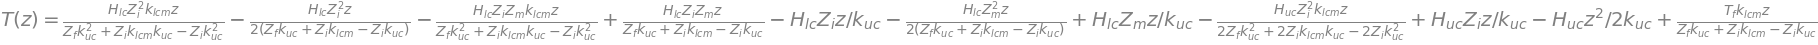

In [80]:
Eq_31_c = Eq_25_c.subs(Qm, sp.solve(Eq_30_c, Qm)[0])
#printeq(sp.expand(Eq_31_c),31.1)
Eq_31_c.expand()

Reemplazando eq.30 en eq.29

**Ecuación final para temperatura en la corteza inferior del modelo M2**

In [81]:
Eq_32 = Eq_29.subs(Qm, sp.solve(Eq_30, Qm)[0])
printeq(sp.expand(Eq_32),32)

<IPython.core.display.Latex object>

In [82]:
Eq_32_c = Eq_29_c.subs(Qm, sp.solve(Eq_30_c, Qm)[0])
printeq(sp.expand(Eq_32_c),32.1)

<IPython.core.display.Latex object>

Reemplazando eq.30 en eq.3

**Ecuación final para temperatura en el manto litosférico del modelo M2**

In [83]:
Eq_33 = Eq_3.subs(Qm, sp.solve(Eq_30, Qm)[0])
printeq(sp.expand(Eq_33),33)

<IPython.core.display.Latex object>

In [84]:
Eq_33_c = Eq_3_c.subs(Qm, sp.solve(Eq_30_c, Qm)[0])
printeq(sp.expand(Eq_33_c),33.1)

<IPython.core.display.Latex object>

Reemplazando eq.30 en eq.24

**Ecuación final para calor en la corteza superior del modelo M2**

In [85]:
Eq_34 = Eq_24.subs(Qm, sp.solve(Eq_30, Qm)[0])
printeq(sp.expand(Eq_34,34),34)

<IPython.core.display.Latex object>

In [86]:
Eq_34_c = Eq_24_c.subs(Qm, sp.solve(Eq_30_c, Qm)[0])
printeq(sp.expand(Eq_34_c),34.1)

<IPython.core.display.Latex object>

Reemplazando eq.30 en eq.20

**Ecuación final para calor en la corteza inferior del modelo M2**

In [87]:
Eq_35 = Eq_20.subs(Qm, sp.solve(Eq_30, Qm)[0])
printeq(sp.expand(Eq_35),35)

<IPython.core.display.Latex object>

In [88]:
Eq_35_c = Eq_20_c.subs(Qm, sp.solve(Eq_30_c, Qm)[0])
printeq(sp.expand(Eq_35_c),35.1)

<IPython.core.display.Latex object>

Reemplazando eq.30 en eq.2

**Ecuación final para calor en manto litosférico del modelo M2**

In [89]:
Eq_36 = Eq_2.subs(Qm, sp.solve(Eq_30, Qm)[0])
printeq(sp.expand(Eq_36),36)

<IPython.core.display.Latex object>

In [90]:
Eq_36_c = Eq_2.subs(Qm, sp.solve(Eq_30_c, Qm)[0])
printeq(sp.expand(Eq_36_c),36.1)

<IPython.core.display.Latex object>

<hr style="color:black"/>

In [91]:
T_z_upper_crust_M2 = sp.lambdify(z,Eq_31.args[1].subs(substitutions))
T_z_lower_crust_M2 = sp.lambdify(z,Eq_32.args[1].subs(substitutions))
T_z_mantle_M2 = sp.lambdify(z,Eq_33.args[1].subs(substitutions))
Q_z_upper_crust_M2 = sp.lambdify(z,Eq_34.args[1].subs(substitutions))
Q_z_lower_crust_M2 = sp.lambdify(z,Eq_35.args[1].subs(substitutions))
Q_z_mantle_M2 = sp.lambdify(z,Eq_36.args[1].subs(substitutions))

T_z_upper_crust_M2_c = sp.lambdify(z,Eq_31_c.args[1].subs(substitutions))
T_z_lower_crust_M2_c = sp.lambdify(z,Eq_32_c.args[1].subs(substitutions))
T_z_mantle_M2_c = sp.lambdify(z,Eq_33_c.args[1].subs(substitutions))
Q_z_upper_crust_M2_c = sp.lambdify(z,Eq_34_c.args[1].subs(substitutions))
Q_z_lower_crust_M2_c = sp.lambdify(z,Eq_35_c.args[1].subs(substitutions))
Q_z_mantle_M2_c = sp.lambdify(z,Eq_36_c.args[1].subs(substitutions))

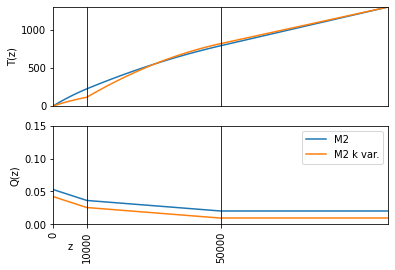

In [92]:
divisor = substitutions[Zf]-substitutions[Zm]
fig, axes = plt.subplots(nrows=2,ncols=3, gridspec_kw={
   'width_ratios': [(substitutions[Zi]-substitutions[Zo])/divisor,
                    (substitutions[Zm]-substitutions[Zi])/divisor,
                    (substitutions[Zf]-substitutions[Zm])/divisor],
    'height_ratios': [1,1]
})
axes[0][0].plot(domain, T_z_upper_crust_M2(domain), label="M2")
axes[0][0].plot(domain, T_z_upper_crust_M2_c(domain), label="M2 k var.")

axes[0][1].plot(domain, T_z_lower_crust_M2(domain), label="M2")
axes[0][1].plot(domain, T_z_lower_crust_M2_c(domain), label="M2 k var.")

axes[0][2].plot(domain, T_z_mantle_M2(domain), label="M2")
axes[0][2].plot(domain, T_z_mantle_M2_c(domain), label="M2 k var.")

axes[1][0].plot(domain, Q_z_upper_crust_M2(domain), label="M2")
axes[1][0].plot(domain, Q_z_upper_crust_M2_c(domain), label="M2 k var.")

axes[1][1].plot(domain, Q_z_lower_crust_M2(domain), label="M2")
axes[1][1].plot(domain, Q_z_lower_crust_M2_c(domain), label="M2 k var.")

axes[1][2].plot(domain, np.repeat(Q_z_mantle_M2(domain),len(domain)), label="M2")
axes[1][2].plot(domain, np.repeat(Q_z_mantle_M2_c(domain),len(domain)), label="M2 k var.")

axes[0][0].set_xlim(substitutions[Zo],substitutions[Zi])
axes[0][1].set_xlim(substitutions[Zi],substitutions[Zm])
axes[0][2].set_xlim(substitutions[Zm],substitutions[Zf])
axes[0][0].set_ylim(0,1300)
axes[0][1].set_ylim(0,1300)
axes[0][2].set_ylim(0,1300)
axes[0][0].set_xticks([])
axes[0][1].set_xticks([])
axes[0][2].set_xticks([])
axes[0][1].set_yticks([])
axes[0][2].set_yticks([])
axes[1][0].set_xlim(substitutions[Zo],substitutions[Zi])
axes[1][1].set_xlim(substitutions[Zi],substitutions[Zm])
axes[1][2].set_xlim(substitutions[Zm],substitutions[Zf])
axes[1][0].set_ylim(0.0,0.15)
axes[1][1].set_ylim(0.0,0.15)
axes[1][2].set_ylim(0.0,0.15)
axes[1][0].set_xticks([substitutions[Zo]])
axes[1][1].set_xticks([substitutions[Zi]])
axes[1][2].set_xticks([substitutions[Zm]])
axes[1][1].set_yticks([])
axes[1][2].set_yticks([])
axes[1][0].tick_params('x', labelrotation=90)
axes[1][1].tick_params('x', labelrotation=90)
axes[1][2].tick_params('x', labelrotation=90)
axes[0][0].set_ylabel("T(z)")
axes[1][0].set_ylabel("Q(z)")
axes[1][0].set_xlabel("z")
fig.subplots_adjust(wspace=0.00)
plt.legend()

In [93]:
print(Q_z_upper_crust_M2(0))
print(Q_z_upper_crust_M2_c(0))

0.052875
0.0421339285714286


In [94]:
print("T_uc(Zi) = ", T_z_upper_crust_M2(substitutions[Zi]))
print("T_lc(Zi) = ", T_z_lower_crust_M2(substitutions[Zi]))
print("")
print("T_lc(Zm) = ", T_z_lower_crust_M2(substitutions[Zm]))
print("T_lm(Zm) = ", T_z_mantle_M2(substitutions[Zm]))
print("")
print("Q_uc(Zi) = ", Q_z_upper_crust_M2(substitutions[Zi]))
print("Q_lc(Zi) = ", Q_z_lower_crust_M2(substitutions[Zi]))
print("")
print("Q_lc(Zm) = ", Q_z_lower_crust_M2(substitutions[Zm]))
print("Q_lm(Zm) = ", Q_z_mantle_M2(substitutions[Zm]))
#print(len(Q_z_upper_crust_M2(domain)))
#print(len(Q_z_lower_crust_M2(domain)))
#print(len(Q_z_mantle_M2(domain)))

T_uc(Zi) =  223.125
T_lc(Zi) =  223.125

T_lc(Zm) =  790.625
T_lm(Zm) =  790.625

Q_uc(Zi) =  0.036375
Q_lc(Zi) =  0.036375000000000005

Q_lc(Zm) =  0.020375
Q_lm(Zm) =  0.020375


In [95]:
print("T_uc(Zi) = ", T_z_upper_crust_M2_c(substitutions[Zi]))
print("T_lc(Zi) = ", T_z_lower_crust_M2_c(substitutions[Zi]))
print("")
print("T_lc(Zm) = ", T_z_lower_crust_M2_c(substitutions[Zm]))
print("T_lm(Zm) = ", T_z_mantle_M2_c(substitutions[Zm]))
print("")
print("Q_uc(Zi) = ", Q_z_upper_crust_M2_c(substitutions[Zi]))
print("Q_lc(Zi) = ", Q_z_lower_crust_M2_c(substitutions[Zi]))
print("")
print("Q_lc(Zm) = ", Q_z_lower_crust_M2_c(substitutions[Zm]))
print("Q_lm(Zm) = ", Q_z_mantle_M2_c(substitutions[Zm]))
#print(len(Q_z_upper_crust_M2(domain)))
#print(len(Q_z_lower_crust_M2(domain)))
#print(len(Q_z_mantle_M2(domain)))

T_uc(Zi) =  112.94642857142873
T_lc(Zi) =  112.94642857142901

T_lc(Zm) =  818.303571428573
T_lm(Zm) =  818.3035714285714

Q_uc(Zi) =  0.0256339285714286
Q_lc(Zi) =  0.0256339285714286

Q_lc(Zm) =  0.009633928571428599
Q_lm(Zm) =  0.00963392857142857


In [96]:
# Comparación gráfica de ambos modelos

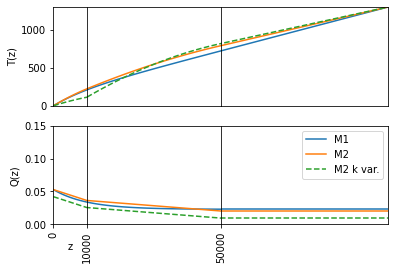

In [97]:
divisor = substitutions[Zf]-substitutions[Zm]
fig, axes = plt.subplots(nrows=2,ncols=3, gridspec_kw={
   'width_ratios': [(substitutions[Zi]-substitutions[Zo])/divisor,
                    (substitutions[Zm]-substitutions[Zi])/divisor,
                    (substitutions[Zf]-substitutions[Zm])/divisor],
    'height_ratios': [1,1]
})
axes[0][0].plot(domain, T_z_crust_M1(domain), label="M1")
axes[0][0].plot(domain, T_z_upper_crust_M2(domain), label="M2")
axes[0][0].plot(domain, T_z_upper_crust_M2_c(domain), '--', label ="M2 k var.")
axes[0][1].plot(domain, T_z_crust_M1(domain), label="M1")
axes[0][1].plot(domain, T_z_lower_crust_M2(domain), label="M2")
axes[0][1].plot(domain, T_z_lower_crust_M2_c(domain), '--', label="M2 k var.")
axes[0][2].plot(domain, T_z_mantle_M1(domain), label="M1")
axes[0][2].plot(domain, T_z_mantle_M2(domain), label="M2")
axes[0][2].plot(domain, T_z_mantle_M2_c(domain), '--', label="M2 k var.")
axes[1][0].plot(domain, Q_z_crust_M1(domain), label="M1")
axes[1][0].plot(domain, Q_z_upper_crust_M2(domain), label="M2")
axes[1][0].plot(domain, Q_z_upper_crust_M2_c(domain), '--', label="M2 k var.")
axes[1][1].plot(domain, Q_z_crust_M1(domain), label="M1")
axes[1][1].plot(domain, Q_z_lower_crust_M2(domain), label="M2")
axes[1][1].plot(domain, Q_z_lower_crust_M2_c(domain), '--', label='M2 k var.')
axes[1][2].plot(domain, np.repeat(Q_z_mantle_M1(domain),len(domain)), label="M1")
axes[1][2].plot(domain, np.repeat(Q_z_mantle_M2(domain),len(domain)), label="M2")
axes[1][2].plot(domain, np.repeat(Q_z_mantle_M2_c(domain),len(domain)), '--', label='M2 k var.')
axes[0][0].set_xlim(substitutions[Zo],substitutions[Zi])
axes[0][1].set_xlim(substitutions[Zi],substitutions[Zm])
axes[0][2].set_xlim(substitutions[Zm],substitutions[Zf])
axes[0][0].set_ylim(0,1300)
axes[0][1].set_ylim(0,1300)
axes[0][2].set_ylim(0,1300)
axes[0][0].set_xticks([])
axes[0][1].set_xticks([])
axes[0][2].set_xticks([])
axes[0][1].set_yticks([])
axes[0][2].set_yticks([])
axes[1][0].set_xlim(substitutions[Zo],substitutions[Zi])
axes[1][1].set_xlim(substitutions[Zi],substitutions[Zm])
axes[1][2].set_xlim(substitutions[Zm],substitutions[Zf])
axes[1][0].set_ylim(0.0,0.15)
axes[1][1].set_ylim(0.0,0.15)
axes[1][2].set_ylim(0.0,0.15)
axes[1][0].set_xticks([substitutions[Zo]])
axes[1][1].set_xticks([substitutions[Zi]])
axes[1][2].set_xticks([substitutions[Zm]])
axes[1][1].set_yticks([])
axes[1][2].set_yticks([])
axes[1][0].tick_params('x', labelrotation=90)
axes[1][1].tick_params('x', labelrotation=90)
axes[1][2].tick_params('x', labelrotation=90)
axes[0][0].set_ylabel("T(z)")
axes[1][0].set_ylabel("Q(z)")
axes[1][0].set_xlabel("z")
fig.subplots_adjust(wspace=0.00)
plt.legend()

# Variables supuestas en gráficos

In [98]:
for key,val in substitutions.items():
    result = "$${} = {}$$".format(sp.latex(key),val)
    display(Latex(result))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>